# Estimating Neural Timescales from Activations

This notebook explores methods to **estimate** neural timescales from unit activations,
without access to the ground truth timescale parameters.

We start by:
1. Loading a network with **homogeneous** neural timescales (all units have the same τ)
2. Extracting time-series of activations for each neuron on a trajectory
3. Computing the autocorrelation of each activation time-series
4. Visualizing both the time-series and autocorrelations side-by-side


Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [2]:
from pathlib import Path
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

from rnns.multitimescale_rnn import MultiTimescaleRNN
from datamodule import PathIntegrationDataModule

In [3]:
# Load from single timescale sweep
sweep_dir = Path("logs/experiments/single_timescales_sweep_20251005_094501")

# Pick a homogeneous timescale experiment (discrete_single_05 = τ=0.5s)
exp_name = "discrete_single_05"
exp_dir = sweep_dir / exp_name / "seed_0"

print(f"Loading from: {exp_dir}")
print(f"Exists: {exp_dir.exists()}")

Loading from: logs/experiments/single_timescales_sweep_20251005_094501/discrete_single_05/seed_0
Exists: True


In [4]:
# Load config
with open(exp_dir / "config_seed0.yaml") as f:
    config = yaml.safe_load(f)

# Load model
model_path = exp_dir / "final_model_seed0.pth"
model = MultiTimescaleRNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],
    dt=config["dt"],
    timescales_config=config.get("timescales_config"),
    learn_timescales=config.get("learn_timescales", False),
)
model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
model.eval()

# Load place cell centers
place_cell_centers = torch.load(
    exp_dir / "place_cell_centers_seed0.pt", weights_only=True
)

# Check the timescales
timescales = model.rnn_step.current_timescales.detach().cpu().numpy()
print(f"\nModel loaded successfully!")
print(f"Hidden size: {config['hidden_size']}")
print(f"Neural timescales: all = {timescales[0]:.4f}s (homogeneous)")
print(f"Unique timescale values: {np.unique(timescales)}")


Model loaded successfully!
Hidden size: 4096
Neural timescales: all = 0.1440s (homogeneous)
Unique timescale values: [0.144]


In [6]:
# Create a data module to generate trajectories
datamodule = PathIntegrationDataModule(
    trajectory_type=config["trajectory_type"],
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=config["num_time_steps"],
    arena_size=config["arena_size"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    DoG=config["DoG"],
    surround_scale=config["surround_scale"],
    place_cell_layout=config["place_cell_layout"],
    behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
    behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
    linear_speed_tau=config.get("linear_speed_tau", 1.0),
    angular_speed_mean=config.get("angular_speed_mean", 0.0),
    angular_speed_std=config.get("angular_speed_std", 1.0),
    angular_speed_tau=config.get("angular_speed_tau", 0.4),
    num_trajectories=100,
    batch_size=100,
    num_workers=10,
    train_val_split=0.0,
)
datamodule.place_cell_centers = place_cell_centers
datamodule.setup()

# Get a batch of trajectories
val_loader = datamodule.val_dataloader()
batch = next(iter(val_loader))
inputs, positions, place_cells = batch

print(f"Inputs shape: {inputs.shape}  (batch, time, input_size)")
print(f"Positions shape: {positions.shape}  (batch, time, 2)")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Inputs shape: torch.Size([100, 20, 2])  (batch, time, input_size)
Positions shape: torch.Size([100, 20, 2])  (batch, time, 2)


In [7]:
# Extract hidden state activations
with torch.no_grad():
    hidden_states, outputs = model(inputs, place_cells[:, 0, :])

print(f"Hidden states shape: {hidden_states.shape}  (batch, time, hidden_size)")

# Focus on a single trajectory for detailed analysis
traj_idx = 0
activations = hidden_states[traj_idx].numpy()  # (time, hidden_size)
print(f"\nSingle trajectory activations shape: {activations.shape}")

Hidden states shape: torch.Size([100, 20, 4096])  (batch, time, hidden_size)

Single trajectory activations shape: (20, 4096)


In [11]:
def compute_autocorrelation(
    signal: np.ndarray, max_lag: int | None = None
) -> np.ndarray:
    """
    Compute the normalized autocorrelation of a 1D signal.

    Args:
        signal: 1D array (time series)
        max_lag: Maximum lag to compute (default: len(signal) // 2)

    Returns:
        autocorr: Autocorrelation values for lags 0 to max_lag
    """
    if max_lag is None:
        max_lag = len(signal) // 2

    # Remove mean (center the signal)
    signal = signal - np.mean(signal)

    # Normalize by variance
    variance = np.var(signal)
    if variance == 0:
        return np.zeros(max_lag + 1)

    autocorr = np.zeros(max_lag + 1)
    n = len(signal)

    for lag in range(max_lag + 1):
        if lag == 0:
            autocorr[lag] = 1.0
        else:
            autocorr[lag] = np.sum(signal[:-lag] * signal[lag:]) / (
                (n - lag) * variance
            )

    return autocorr


# Compute autocorrelation for all units
num_timesteps = activations.shape[0]
max_lag = num_timesteps // 2
lags = np.arange(max_lag + 1) * config["dt"]  # Convert to seconds

autocorrelations = np.zeros((config["hidden_size"], max_lag + 1))
for unit_idx in range(config["hidden_size"]):
    autocorrelations[unit_idx] = compute_autocorrelation(
        activations[:, unit_idx], max_lag
    )

print(f"Autocorrelations computed for {config['hidden_size']} units")
print(f"Lag range: 0 to {lags[-1]:.2f}s ({max_lag} steps)")

Autocorrelations computed for 4096 units
Lag range: 0 to 1.00s (10 steps)


## Visualize Activations and Autocorrelations

Show 6 selected units with their time series on the left and autocorrelation on the right.

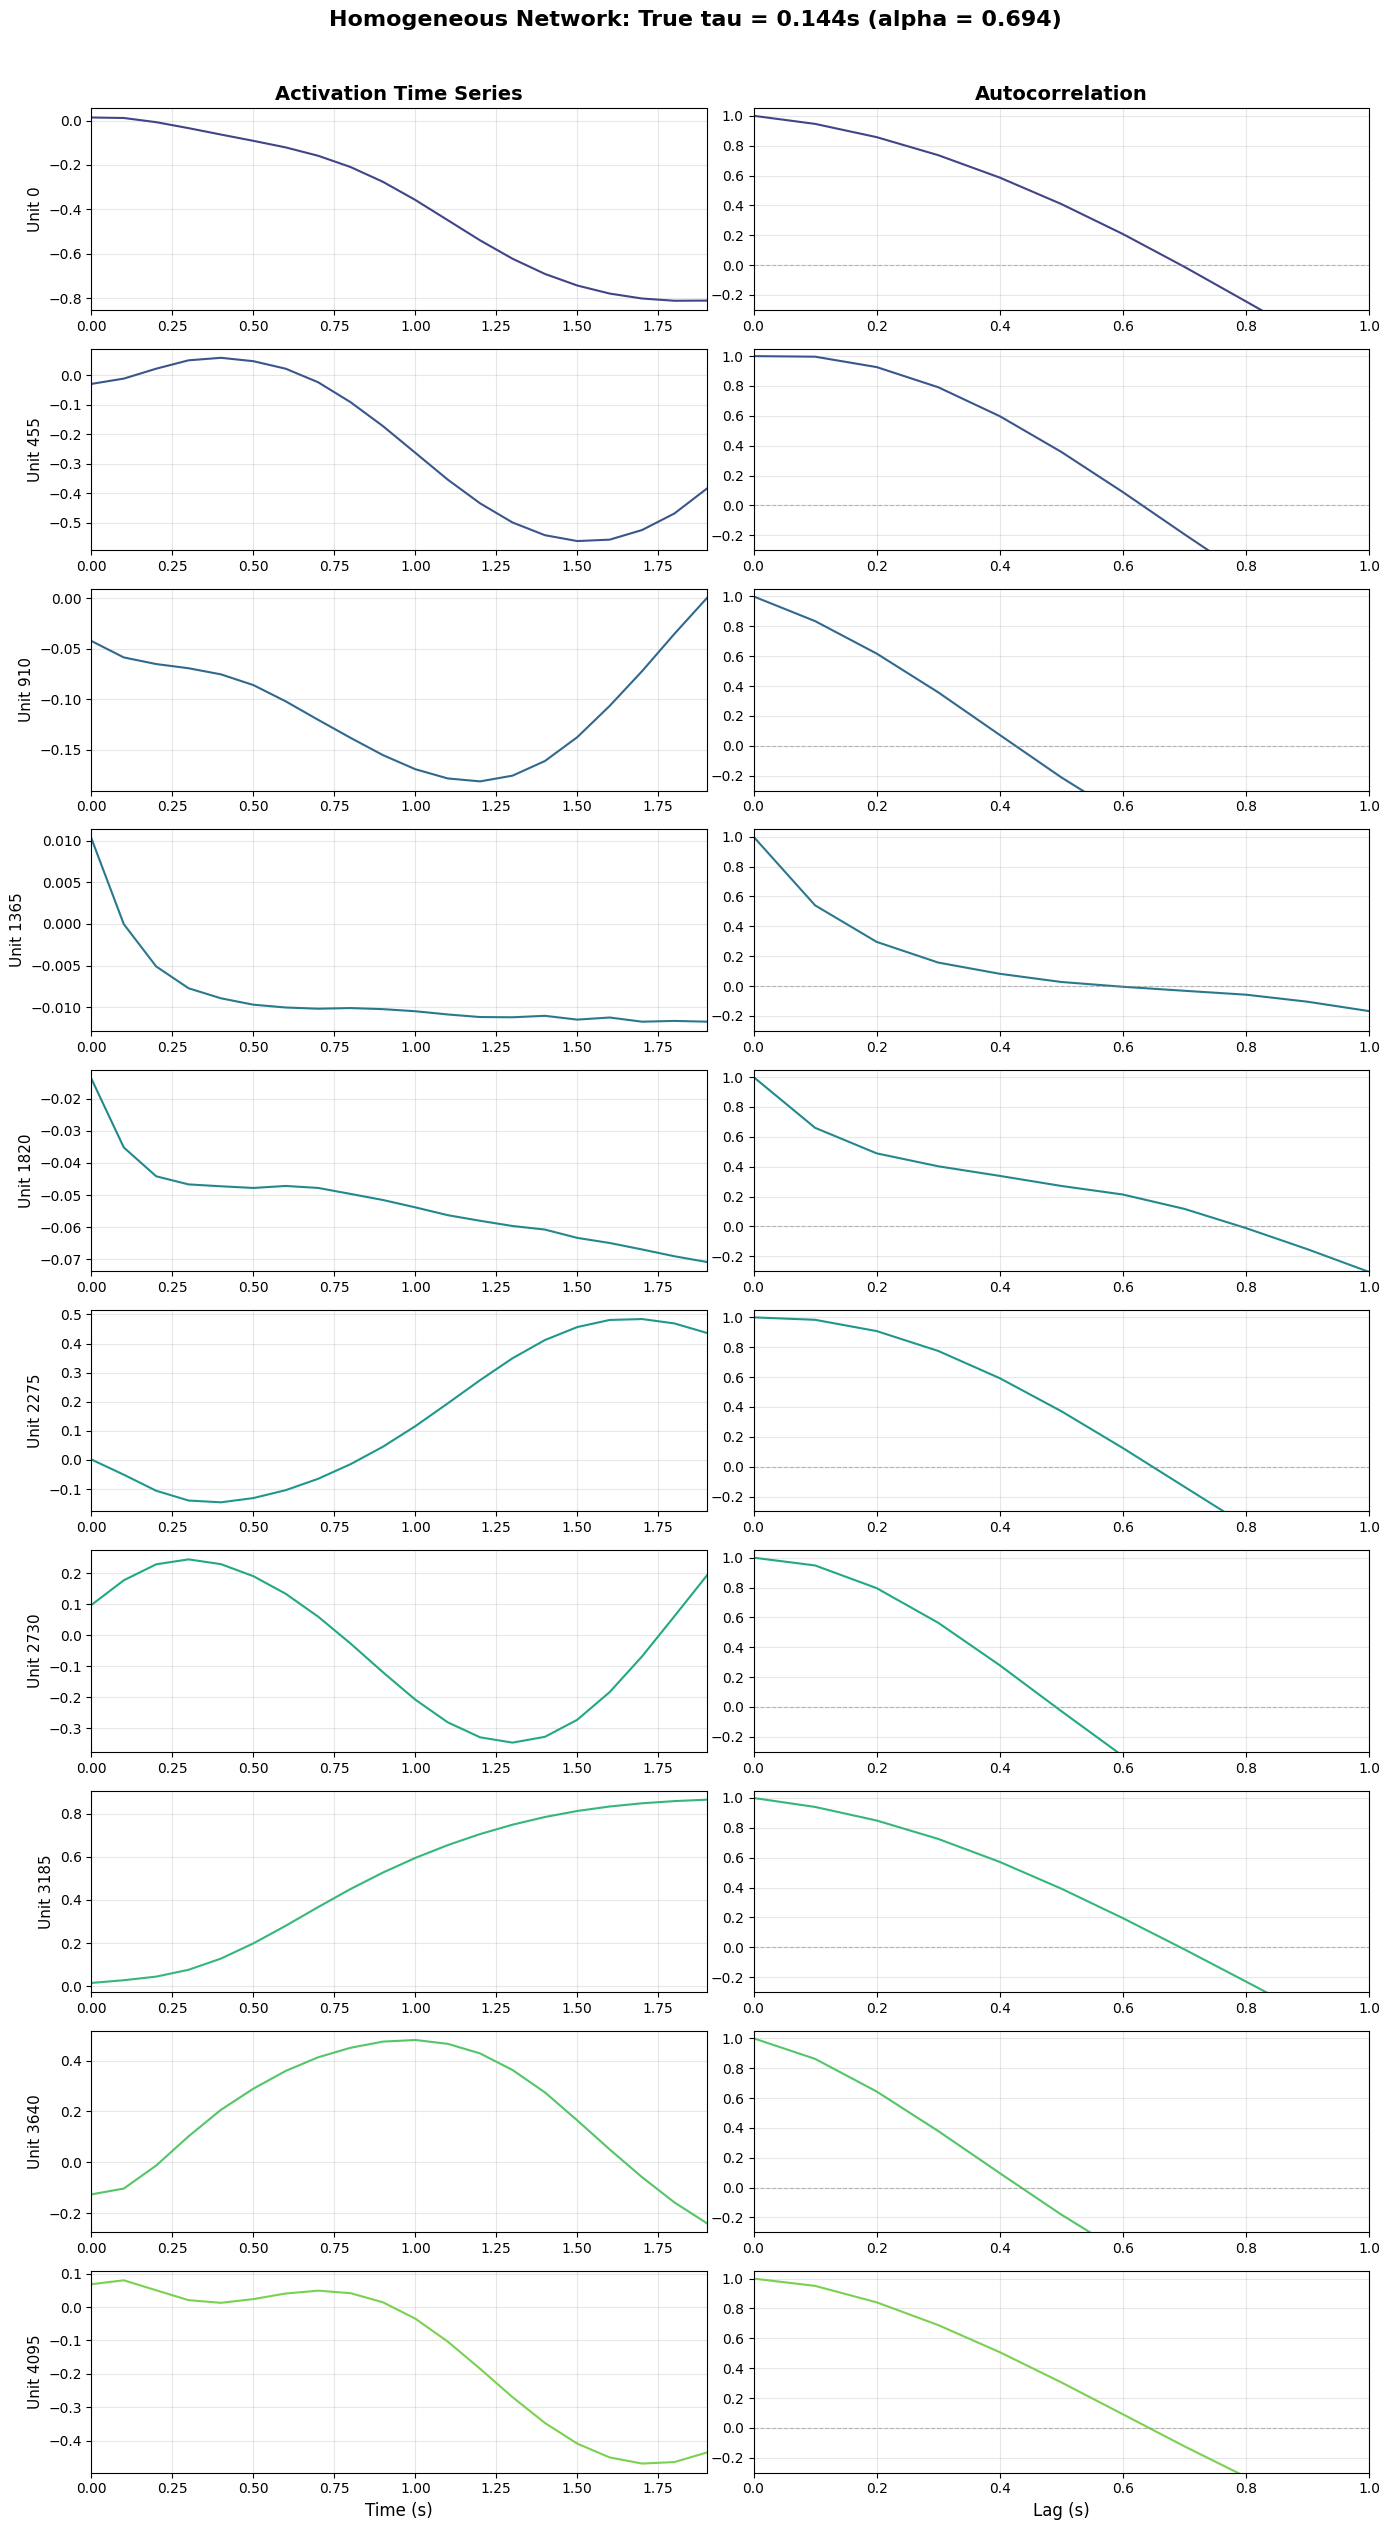

In [13]:
# Select 6 units for visualization (evenly spaced)
num_units_to_plot = 10
unit_indices = np.linspace(0, config["hidden_size"] - 1, num_units_to_plot, dtype=int)


num_timesteps = activations.shape[0]
# Time axis
time = np.arange(num_timesteps) * config["dt"]

# Create figure with 6 rows, 2 columns
fig, axes = plt.subplots(num_units_to_plot, 2, figsize=(14, 2.5 * num_units_to_plot))

# Color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, num_units_to_plot))

for i, unit_idx in enumerate(unit_indices):
    # Left: Activation time series
    ax_ts = axes[i, 0]
    ax_ts.plot(time, activations[:, unit_idx], color=colors[i], linewidth=1.5)
    ax_ts.set_ylabel(f"Unit {unit_idx}", fontsize=11)
    ax_ts.set_xlim(0, time[-1])
    ax_ts.grid(True, alpha=0.3)
    if i == 0:
        ax_ts.set_title("Activation Time Series", fontsize=14, fontweight="bold")
    if i == num_units_to_plot - 1:
        ax_ts.set_xlabel("Time (s)", fontsize=12)

    # Right: Autocorrelation
    ax_ac = axes[i, 1]
    ax_ac.plot(lags, autocorrelations[unit_idx], color=colors[i], linewidth=1.5)
    ax_ac.axhline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
    ax_ac.set_xlim(0, lags[-1])
    ax_ac.set_ylim(-0.3, 1.05)
    ax_ac.grid(True, alpha=0.3)
    if i == 0:
        ax_ac.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    if i == num_units_to_plot - 1:
        ax_ac.set_xlabel("Lag (s)", fontsize=12)

# Add true timescale reference
true_tau = timescales[0]
fig.suptitle(
    f"Homogeneous Network: True tau = {true_tau:.3f}s (alpha = {config['dt']/true_tau:.3f})",
    fontsize=16,
    fontweight="bold",
    y=1.01,
)

plt.tight_layout()
plt.show()

## Autocorrelation Statistics Across All Units


In [ ]:
# Compute mean and std of autocorrelation across all units
mean_autocorr = np.mean(autocorrelations, axis=0)
std_autocorr = np.std(autocorrelations, axis=0)

# Theoretical autocorrelation for a leaky integrator with timescale tau
# For a discrete-time leaky integrator: autocorr(k) approx (1-alpha)^k
true_tau = timescales[0]
alpha = config["dt"] / true_tau
theoretical_autocorr = (1 - alpha) ** (np.arange(max_lag + 1))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot all individual autocorrelations (faded)
for unit_idx in range(config["hidden_size"]):
    ax.plot(lags, autocorrelations[unit_idx], color='lightblue', alpha=0.1, linewidth=0.5)

# Plot mean with shaded std
ax.fill_between(lags, mean_autocorr - std_autocorr, mean_autocorr + std_autocorr, 
                alpha=0.3, color='tab:blue', label='Mean +/- Std')
ax.plot(lags, mean_autocorr, color='tab:blue', linewidth=2.5, label='Mean Autocorrelation')

# Plot theoretical
ax.plot(lags, theoretical_autocorr, color='red', linewidth=2, linestyle='--',
        label=f'Theoretical: (1-alpha)^k, tau={true_tau:.3f}s')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.set_xlabel("Lag (s)", fontsize=14)
ax.set_ylabel("Autocorrelation", fontsize=14)
ax.set_title(f"Autocorrelation of Hidden Unit Activations\n(Homogeneous tau = {true_tau:.3f}s)", fontsize=16)
ax.legend(fontsize=11, loc='upper right')
ax.set_xlim(0, lags[-1])
ax.set_ylim(-0.2, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nTrue neural timescale: tau = {true_tau:.4f}s")
print(f"True alpha (update rate): alpha = dt/tau = {alpha:.4f}")
print(f"\nAutocorrelation at lag=1 step:")
print(f"  Observed: {mean_autocorr[1]:.4f} +/- {std_autocorr[1]:.4f}")
print(f"  Theoretical (1-alpha): {1-alpha:.4f}")
